# LLM Evaluation Analysis

**Purpose**: Analyze experiment results to compare model performance across tasks and prompting strategies.

**Research Questions**:
1. How does model size affect performance?
2. What is the effectiveness of zero-shot vs. few-shot prompting?
3. Does chain-of-thought improve reasoning for standard models?
4. How do reasoning-specialized models compare to standard models?
5. Which tasks benefit most from different prompting strategies?

---

## 1. Setup

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Any
from scipy import stats
from datetime import datetime

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✓ Imports complete")

✓ Imports complete


## 2. Data Loading

In [3]:
def load_results(results_dir: str = "results/raw_outputs") -> pd.DataFrame:
    """
    Load experiment results into DataFrame.
    
    Returns:
        DataFrame with columns: experiment_id, task_id, model, strategy, 
                                prompt, response, tokens, duration, etc.
    """
    results_path = Path(results_dir)
    
    data = []
    for filepath in results_path.glob("*.json"):
        with open(filepath, 'r') as f:
            result = json.load(f)
            
            # Skip failed experiments
            if result.get('error'):
                continue
            
            data.append({
                'experiment_id': filepath.stem,
                'task_id': result['config']['task_id'],
                'model': result['config']['model'],
                'strategy': result['config']['strategy'],
                'prompt': result['prompt'],
                'response': result['response'],
                'prompt_tokens': result['model_metadata']['prompt_tokens'],
                'response_tokens': result['model_metadata']['response_tokens'],
                'duration': result['model_metadata']['total_duration'],
                'cached': result['model_metadata']['cached'],
                'timestamp': result['timestamp']
            })
    
    df = pd.DataFrame(data)
    print(f"Loaded {len(df)} experiment results")
    return df


def load_scores(scores_dir: str = "results/scores") -> pd.DataFrame:
    """
    Load evaluation scores into DataFrame.
    
    Returns:
        DataFrame with columns: experiment_id, task_id, model, strategy,
                                criterion scores, mean_score, etc.
    """
    scores_path = Path(scores_dir)
    
    data = []
    for filepath in scores_path.glob("*.json"):
        with open(filepath, 'r') as f:
            score = json.load(f)
            
            # Base row
            row = {
                'experiment_id': score['experiment_id'],
                'task_id': score['task_id'],
                'model': score['model'],
                'strategy': score['strategy'],
                'mean_score': score['mean_score'],
                'overall_notes': score['overall_notes'],
                'scorer': score['scorer'],
                'timestamp': score['timestamp']
            }
            
            # Add individual criterion scores
            for cs in score['criterion_scores']:
                row[f"score_{cs['criterion_name']}"] = cs['score']
                row[f"justification_{cs['criterion_name']}"] = cs['justification']
            
            data.append(row)
    
    df = pd.DataFrame(data)
    print(f"Loaded {len(df)} scores")
    return df


# Load data
results_df = load_results()
scores_df = load_scores()

# Merge
df = pd.merge(results_df, scores_df, on='experiment_id', suffixes=('_result', '_score'))

# Clean up duplicate columns
df['task_id'] = df['task_id_result']
df['model'] = df['model_result']
df['strategy'] = df['strategy_result']
df = df.drop(columns=['task_id_result', 'task_id_score', 'model_result', 'model_score', 
                       'strategy_result', 'strategy_score'])

print(f"\n✓ Combined dataset: {len(df)} experiments")
print(f"Models: {df['model'].unique().tolist()}")
print(f"Strategies: {df['strategy'].unique().tolist()}")
print(f"Tasks: {df['task_id'].nunique()}")

Loaded 50 experiment results
Loaded 50 scores

✓ Combined dataset: 50 experiments
Models: ['ministral-3:3b', 'deepseek-r1:7b']
Strategies: ['cot', 'zero_shot', 'few_shot']
Tasks: 10


In [4]:
# Quick data inspection
df.head()

,experiment_id,prompt,response,prompt_tokens,response_tokens,duration,cached,timestamp_result,mean_score,overall_notes,...,justification_Practicality,score_Explanation Clarity,justification_Explanation Clarity,score_Code Quality,justification_Code Quality,score_Documentation,justification_Documentation,task_id,model,strategy
0,task_01_instruction__ministral-3_3b__cot,Follow a multi-step instruction with specific ...,**Product Review:**\n\nThe **EcoTower Laptop S...,635,116,1.594749,False,2026-01-08T23:09:19.492006,3.666667,[No overall notes],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,task_01_instruction,ministral-3:3b,cot
1,task_01_instruction__deepseek-r1_7b__zero_shot,Follow a multi-step instruction with specific ...,The laptop stand is $35 and effectively keeps ...,76,458,16.562679,False,2026-01-08T23:09:36.057404,4.333333,[No overall notes],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,task_01_instruction,deepseek-r1:7b,zero_shot
2,task_02_logic__ministral-3_3b__zero_shot,Determine if the conclusion logically follows ...,(1) **Valid**\n(2) **Explanation:**\n\nThe con...,615,150,2.585432,False,2026-01-08T23:09:51.179332,5.000000,[No overall notes],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,task_02_logic,ministral-3:3b,zero_shot
3,task_10_ethics__ministral-3_3b__few_shot,Analyze the ethical dilemma. Consider multiple...,This ethical dilemma involves complex tensions...,1260,1976,28.031445,False,2026-01-08T23:18:58.381465,4.750000,[No overall notes],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,task_10_ethics,ministral-3:3b,few_shot
4,task_05_comprehension__deepseek-r1_7b__zero_shot,Read the passage and answer the question. Your...,The passage suggests that people's engagement ...,146,486,13.913058,False,2026-01-08T23:13:58.381111,5.000000,[No overall notes],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,task_05_comprehension,deepseek-r1:7b,zero_shot


## 3. Data Exploration

In [5]:
# Basic statistics
print("=" * 60)
print("OVERALL STATISTICS")
print("=" * 60)

print(f"\nMean Score: {df['mean_score'].mean():.2f} (±{df['mean_score'].std():.2f})")
print(f"Score Range: {df['mean_score'].min():.2f} - {df['mean_score'].max():.2f}")
print(f"Median Score: {df['mean_score'].median():.2f}")

print("\nDistribution by Score:")
print(df['mean_score'].describe())

OVERALL STATISTICS

Mean Score: 4.58 (±0.79)
Score Range: 1.67 - 5.00
Median Score: 5.00

Distribution by Score:
count    50.000000
mean      4.584933
std       0.792291
min       1.666667
25%       4.500000
50%       5.000000
75%       5.000000
max       5.000000
Name: mean_score, dtype: float64


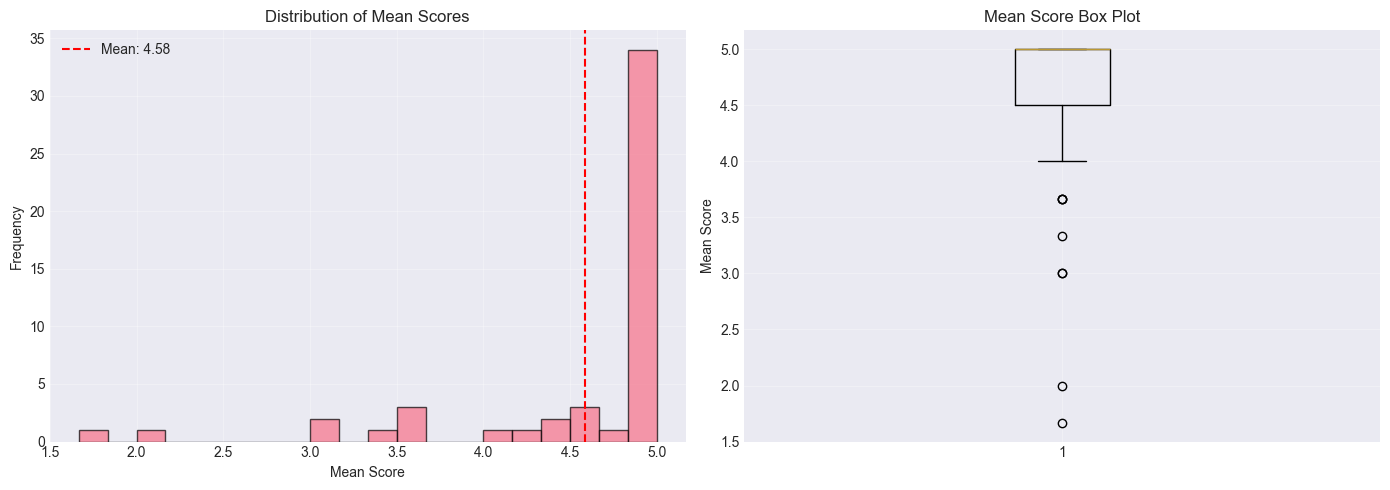

✓ Saved: results/figures/score_distribution.png


In [6]:
# Score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['mean_score'], bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(df['mean_score'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df["mean_score"].mean():.2f}')
axes[0].set_xlabel('Mean Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Mean Scores')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(df['mean_score'], vert=True)
axes[1].set_ylabel('Mean Score')
axes[1].set_title('Mean Score Box Plot')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('results/figures/score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: results/figures/score_distribution.png")

## 4. Model Comparison

In [7]:
# Aggregate by model
model_stats = df.groupby('model').agg({
    'mean_score': ['mean', 'std', 'count'],
    'response_tokens': 'mean',
    'duration': 'mean'
}).round(2)

model_stats.columns = ['_'.join(col).strip() for col in model_stats.columns.values]
model_stats = model_stats.rename(columns={
    'mean_score_mean': 'mean_score',
    'mean_score_std': 'std_score',
    'mean_score_count': 'n_experiments',
    'response_tokens_mean': 'avg_response_tokens',
    'duration_mean': 'avg_duration_sec'
})

print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(model_stats)
print()

MODEL COMPARISON
                mean_score  std_score  n_experiments  avg_response_tokens  \
model                                                                       
deepseek-r1:7b        4.50       0.88             20               732.45   
ministral-3:3b        4.64       0.74             30               620.73   

                avg_duration_sec  
model                             
deepseek-r1:7b             20.95  
ministral-3:3b              8.69  



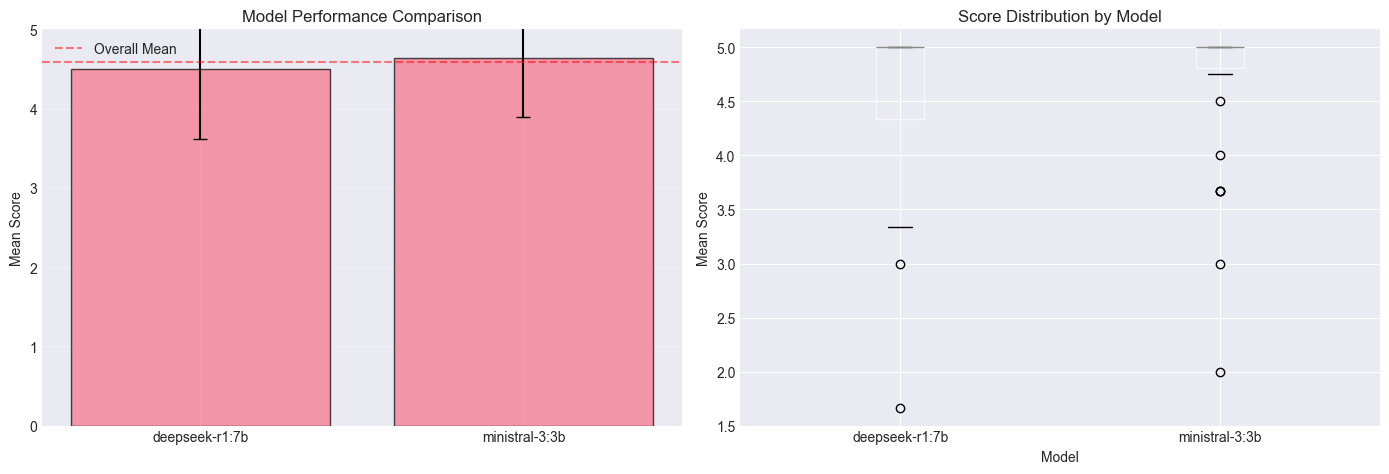

✓ Saved: results/figures/model_comparison.png


In [8]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart: mean scores
models = model_stats.index
scores = model_stats['mean_score']
stds = model_stats['std_score']

axes[0].bar(models, scores, yerr=stds, capsize=5, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Mean Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_ylim([0, 5])
axes[0].axhline(y=df['mean_score'].mean(), color='r', linestyle='--', 
                label='Overall Mean', alpha=0.5)
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# Box plot: score distributions by model
df.boxplot(column='mean_score', by='model', ax=axes[1])
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Mean Score')
axes[1].set_title('Score Distribution by Model')
axes[1].get_figure().suptitle('')  # Remove auto-generated title

plt.tight_layout()
plt.savefig('results/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: results/figures/model_comparison.png")

## 5. Strategy Comparison

In [9]:
# Aggregate by strategy
strategy_stats = df.groupby('strategy').agg({
    'mean_score': ['mean', 'std', 'count']
}).round(2)

strategy_stats.columns = ['_'.join(col).strip() for col in strategy_stats.columns.values]
strategy_stats = strategy_stats.rename(columns={
    'mean_score_mean': 'mean_score',
    'mean_score_std': 'std_score',
    'mean_score_count': 'n_experiments'
})

print("=" * 60)
print("STRATEGY COMPARISON")
print("=" * 60)
print(strategy_stats)
print()

STRATEGY COMPARISON
           mean_score  std_score  n_experiments
strategy                                       
cot              4.47       1.00             10
few_shot         4.86       0.34             20
zero_shot        4.37       0.95             20



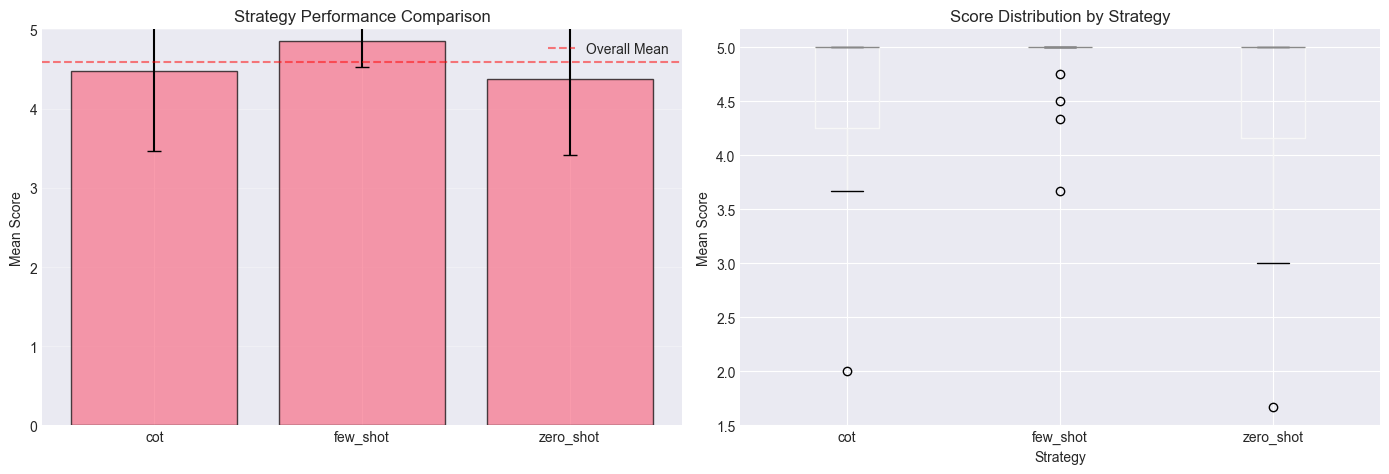

✓ Saved: results/figures/strategy_comparison.png


In [10]:
# Visualize strategy comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
strategies = strategy_stats.index
scores = strategy_stats['mean_score']
stds = strategy_stats['std_score']

axes[0].bar(strategies, scores, yerr=stds, capsize=5, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Mean Score')
axes[0].set_title('Strategy Performance Comparison')
axes[0].set_ylim([0, 5])
axes[0].axhline(y=df['mean_score'].mean(), color='r', linestyle='--', 
                label='Overall Mean', alpha=0.5)
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# Box plot
df.boxplot(column='mean_score', by='strategy', ax=axes[1])
axes[1].set_xlabel('Strategy')
axes[1].set_ylabel('Mean Score')
axes[1].set_title('Score Distribution by Strategy')
axes[1].get_figure().suptitle('')

plt.tight_layout()
plt.savefig('results/figures/strategy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: results/figures/strategy_comparison.png")

## 6. Model × Strategy Interaction

In [11]:
# Aggregate by model and strategy
model_strategy_stats = df.groupby(['model', 'strategy'])['mean_score'].agg(['mean', 'std', 'count']).round(2)
model_strategy_stats = model_strategy_stats.rename(columns={'mean': 'mean_score', 'std': 'std_score', 'count': 'n'})

print("=" * 60)
print("MODEL × STRATEGY INTERACTION")
print("=" * 60)
print(model_strategy_stats)
print()

MODEL × STRATEGY INTERACTION
                          mean_score  std_score   n
model          strategy                            
deepseek-r1:7b few_shot         4.88       0.25  10
               zero_shot        4.12       1.12  10
ministral-3:3b cot              4.47       1.00  10
               few_shot         4.84       0.42  10
               zero_shot        4.62       0.71  10



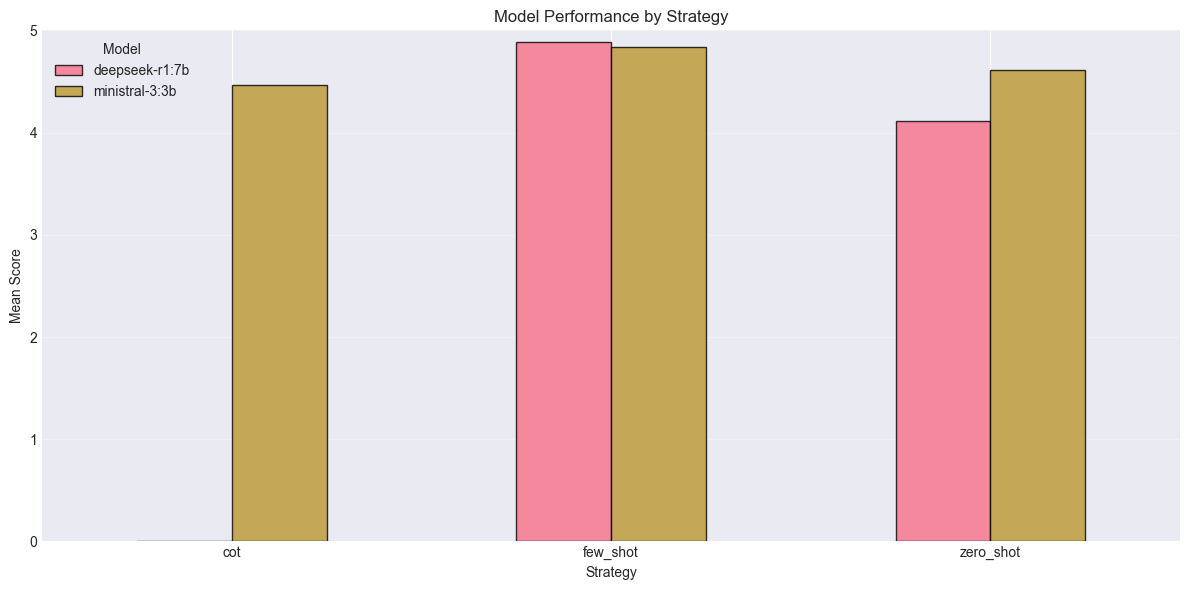

✓ Saved: results/figures/model_strategy_interaction.png


In [12]:
# Grouped bar chart: model × strategy
pivot_data = df.pivot_table(values='mean_score', index='strategy', columns='model', aggfunc='mean')

ax = pivot_data.plot(kind='bar', figsize=(12, 6), alpha=0.8, edgecolor='black')
ax.set_ylabel('Mean Score')
ax.set_xlabel('Strategy')
ax.set_title('Model Performance by Strategy')
ax.set_ylim([0, 5])
ax.legend(title='Model')
ax.grid(alpha=0.3, axis='y')
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig('results/figures/model_strategy_interaction.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: results/figures/model_strategy_interaction.png")

## 7. Task-Level Analysis

In [13]:
# Aggregate by task
task_stats = df.groupby('task_id')['mean_score'].agg(['mean', 'std', 'min', 'max']).round(2)
task_stats = task_stats.sort_values('mean', ascending=False)

print("=" * 60)
print("TASK DIFFICULTY RANKING (by mean score)")
print("=" * 60)
print(task_stats)
print()

# Identify easiest and hardest tasks
easiest_task = task_stats.index[0]
hardest_task = task_stats.index[-1]

print(f"Easiest task: {easiest_task} (mean: {task_stats.loc[easiest_task, 'mean']:.2f})")
print(f"Hardest task: {hardest_task} (mean: {task_stats.loc[hardest_task, 'mean']:.2f})")

TASK DIFFICULTY RANKING (by mean score)
                       mean   std   min  max
task_id                                     
task_02_logic          5.00  0.00  5.00  5.0
task_04_code           5.00  0.00  5.00  5.0
task_05_comprehension  5.00  0.00  5.00  5.0
task_03_creative       4.90  0.22  4.50  5.0
task_09_math           4.87  0.30  4.33  5.0
task_08_factual        4.60  0.89  3.00  5.0
task_10_ethics         4.55  0.37  4.00  5.0
task_01_instruction    4.47  0.56  3.67  5.0
task_07_ambiguity      3.93  1.53  1.67  5.0
task_06_commonsense    3.53  1.07  2.00  5.0

Easiest task: task_02_logic (mean: 5.00)
Hardest task: task_06_commonsense (mean: 3.53)


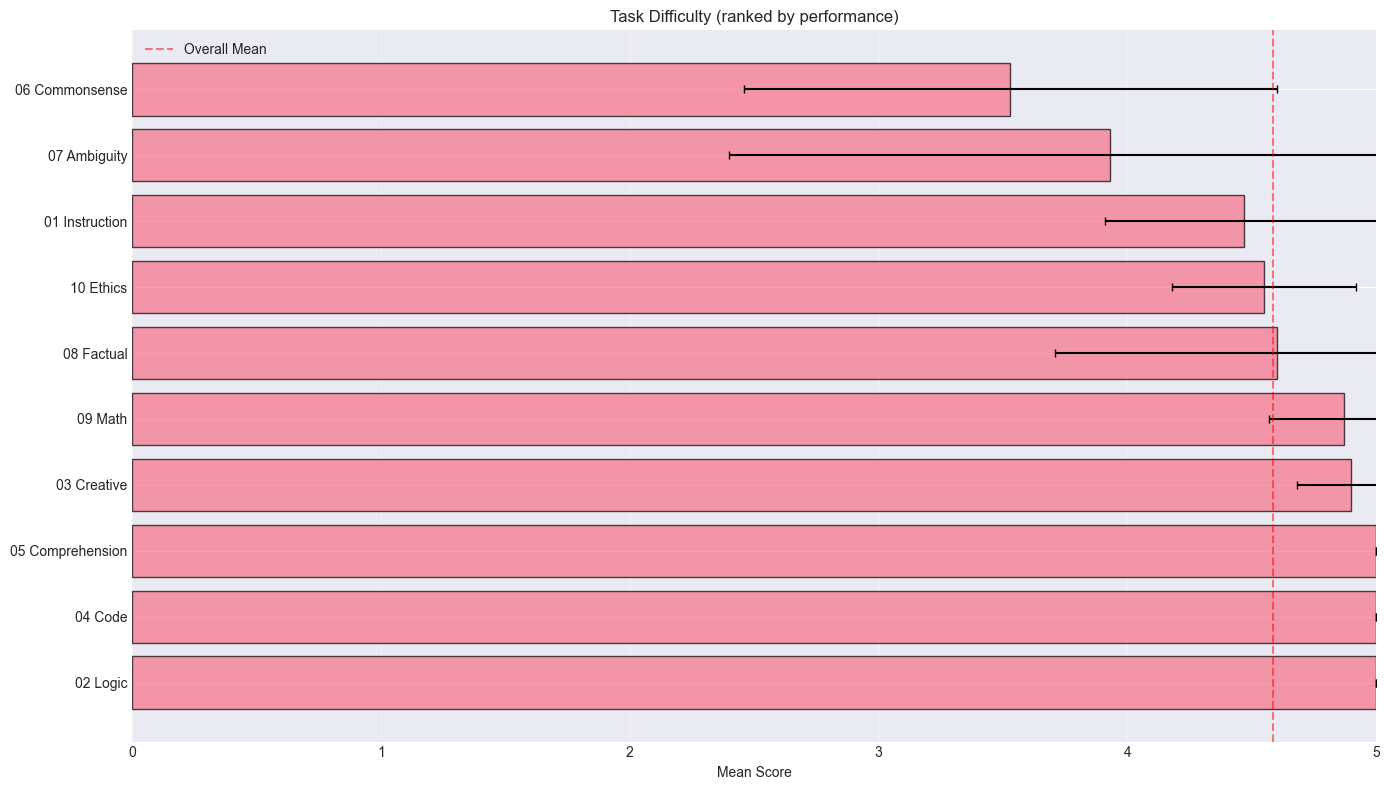

✓ Saved: results/figures/task_difficulty.png


In [14]:
# Visualize task difficulty
fig, ax = plt.subplots(figsize=(14, 8))

tasks = task_stats.index
scores = task_stats['mean']
stds = task_stats['std']

# Shorten task names for display
task_labels = [t.replace('task_', '').replace('_', ' ').title()[:30] for t in tasks]

y_pos = np.arange(len(tasks))
ax.barh(y_pos, scores, xerr=stds, capsize=3, alpha=0.7, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(task_labels)
ax.set_xlabel('Mean Score')
ax.set_title('Task Difficulty (ranked by performance)')
ax.set_xlim([0, 5])
ax.axvline(x=df['mean_score'].mean(), color='r', linestyle='--', 
            label='Overall Mean', alpha=0.5)
ax.legend()
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('results/figures/task_difficulty.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: results/figures/task_difficulty.png")

## 8. Heatmap: Tasks × Strategies

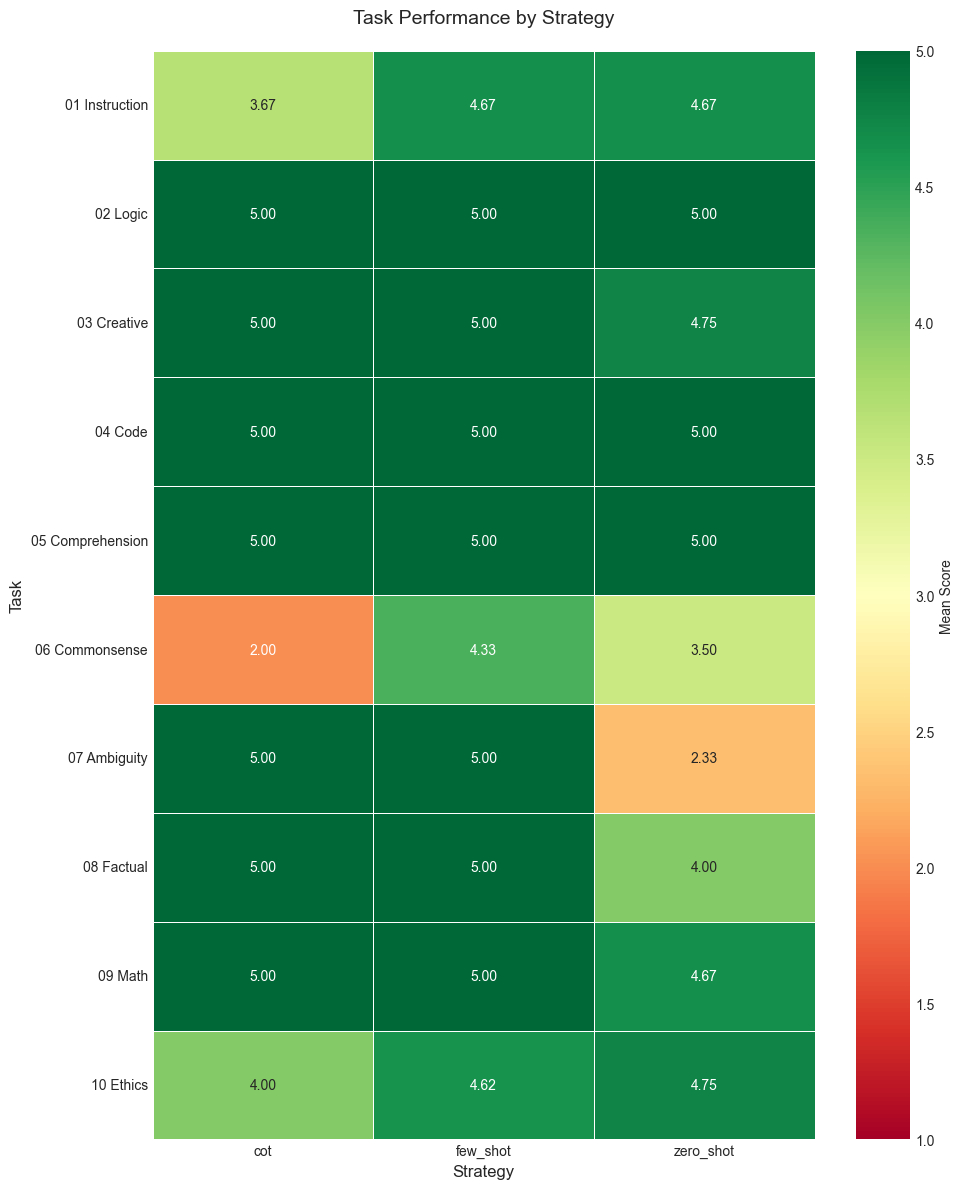

✓ Saved: results/figures/task_strategy_heatmap.png


In [15]:
# Create pivot table for heatmap
heatmap_data = df.pivot_table(
    values='mean_score',
    index='task_id',
    columns='strategy',
    aggfunc='mean'
)

# Shorten task names
heatmap_data.index = [t.replace('task_', '').replace('_', ' ').title()[:25] 
                       for t in heatmap_data.index]

# Create heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    center=3.0,
    vmin=1,
    vmax=5,
    cbar_kws={'label': 'Mean Score'},
    linewidths=0.5
)

plt.title('Task Performance by Strategy', fontsize=14, pad=20)
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('Task', fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('results/figures/task_strategy_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: results/figures/task_strategy_heatmap.png")

## 9. Statistical Tests

In [16]:
print("=" * 60)
print("STATISTICAL SIGNIFICANCE TESTS")
print("=" * 60)
print()

# Test 1: Model comparison (independent samples t-test)
models = df['model'].unique()
if len(models) == 2:
    model1, model2 = models
    scores1 = df[df['model'] == model1]['mean_score']
    scores2 = df[df['model'] == model2]['mean_score']
    
    t_stat, p_value = stats.ttest_ind(scores1, scores2)
    
    print(f"Model Comparison: {model1} vs {model2}")
    print(f"  Mean scores: {scores1.mean():.2f} vs {scores2.mean():.2f}")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")
    print()

# Test 2: Strategy comparison for standard model (paired if same tasks)
# Get the standard model (one with CoT)
standard_model = None
for model in df['model'].unique():
    if df[(df['model'] == model) & (df['strategy'] == 'cot')].shape[0] > 0:
        standard_model = model
        break

if standard_model:
    model_df = df[df['model'] == standard_model]
    
    strategies = model_df['strategy'].unique()
    
    # Compare zero-shot vs few-shot (paired)
    if 'zero_shot' in strategies and 'few_shot' in strategies:
        # Get paired observations (same task)
        zero_df = model_df[model_df['strategy'] == 'zero_shot'].set_index('task_id')['mean_score']
        few_df = model_df[model_df['strategy'] == 'few_shot'].set_index('task_id')['mean_score']
        
        # Only paired tasks
        common_tasks = zero_df.index.intersection(few_df.index)
        zero_paired = zero_df[common_tasks]
        few_paired = few_df[common_tasks]
        
        if len(common_tasks) > 0:
            t_stat, p_value = stats.ttest_rel(zero_paired, few_paired)
            
            print(f"Strategy Comparison ({standard_model}): Zero-shot vs Few-shot")
            print(f"  Paired tasks: {len(common_tasks)}")
            print(f"  Mean scores: {zero_paired.mean():.2f} vs {few_paired.mean():.2f}")
            print(f"  Mean difference: {(few_paired - zero_paired).mean():.2f}")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.4f}")
            print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")
            print()
    
    # Compare zero-shot vs CoT (paired)
    if 'zero_shot' in strategies and 'cot' in strategies:
        zero_df = model_df[model_df['strategy'] == 'zero_shot'].set_index('task_id')['mean_score']
        cot_df = model_df[model_df['strategy'] == 'cot'].set_index('task_id')['mean_score']
        
        common_tasks = zero_df.index.intersection(cot_df.index)
        zero_paired = zero_df[common_tasks]
        cot_paired = cot_df[common_tasks]
        
        if len(common_tasks) > 0:
            t_stat, p_value = stats.ttest_rel(zero_paired, cot_paired)
            
            print(f"Strategy Comparison ({standard_model}): Zero-shot vs Chain-of-Thought")
            print(f"  Paired tasks: {len(common_tasks)}")
            print(f"  Mean scores: {zero_paired.mean():.2f} vs {cot_paired.mean():.2f}")
            print(f"  Mean difference: {(cot_paired - zero_paired).mean():.2f}")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.4f}")
            print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")
            print()

# Test 3: ANOVA for strategy comparison
strategy_groups = [df[df['strategy'] == s]['mean_score'].values for s in df['strategy'].unique()]
f_stat, p_value = stats.f_oneway(*strategy_groups)

print(f"ANOVA: Strategy effect across all models")
print(f"  F-statistic: {f_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")
print()

print("=" * 60)

STATISTICAL SIGNIFICANCE TESTS

Model Comparison: ministral-3:3b vs deepseek-r1:7b
  Mean scores: 4.64 vs 4.50
  t-statistic: 0.6162
  p-value: 0.5407
  Significant at α=0.05: No

Strategy Comparison (ministral-3:3b): Zero-shot vs Few-shot
  Paired tasks: 10
  Mean scores: 4.62 vs 4.84
  Mean difference: 0.23
  t-statistic: -1.1319
  p-value: 0.2869
  Significant at α=0.05: No

Strategy Comparison (ministral-3:3b): Zero-shot vs Chain-of-Thought
  Paired tasks: 10
  Mean scores: 4.62 vs 4.47
  Mean difference: -0.15
  t-statistic: 0.4858
  p-value: 0.6387
  Significant at α=0.05: No

ANOVA: Strategy effect across all models
  F-statistic: 2.2018
  p-value: 0.1219
  Significant at α=0.05: No



## 10. Criterion-Level Analysis

CRITERION-LEVEL PERFORMANCE
Narrative Structure: 5.00
Comprehension Depth: 5.00
Code Quality: 5.00
Character Development: 5.00
Creativity: 5.00
Answer Completeness: 5.00
Inference Quality: 5.00
Documentation: 5.00
Identification of Trade-offs: 5.00
Multiple Perspectives: 5.00
Clarity: 5.00
Naturalness: 5.00
Logical Reasoning: 5.00
Correctness: 5.00
Problem-Solving Process: 4.80
Mathematical Communication: 4.80
Reasoning Depth: 4.60
Completeness: 4.60
Linguistic Explanation: 4.60
Epistemic Humility: 4.60
Factual Accuracy: 4.60
Writing Quality: 4.60
Content Quality: 4.60
Explanation Clarity: 4.20
Interpretation Quality: 3.80
Format Compliance: 3.80
Avoidance of False Balance: 3.60
Ambiguity Identification: 3.40
Physical Reasoning: 3.20
Practicality: 3.20



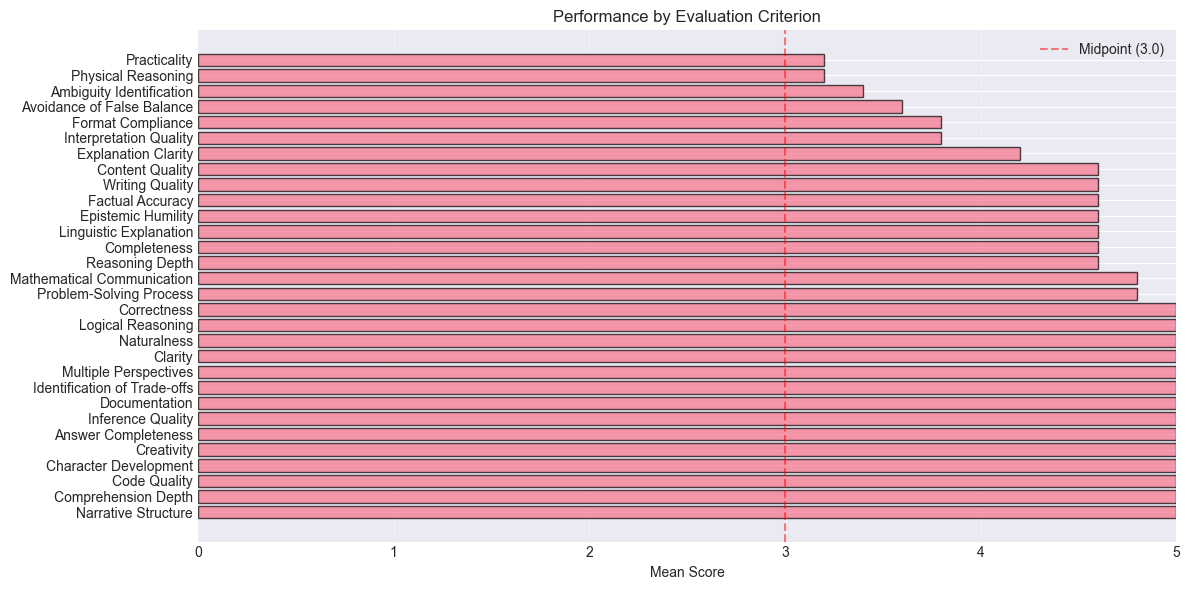

✓ Saved: results/figures/criterion_performance.png


In [17]:
# Extract criterion columns
criterion_cols = [col for col in df.columns if col.startswith('score_')]

if criterion_cols:
    # Calculate mean for each criterion
    criterion_means = df[criterion_cols].mean().sort_values(ascending=False)
    
    # Clean names
    criterion_names = [col.replace('score_', '') for col in criterion_means.index]
    
    print("=" * 60)
    print("CRITERION-LEVEL PERFORMANCE")
    print("=" * 60)
    for name, score in zip(criterion_names, criterion_means.values):
        print(f"{name}: {score:.2f}")
    print()
    
    # Visualize
    plt.figure(figsize=(12, 6))
    plt.barh(criterion_names, criterion_means.values, alpha=0.7, edgecolor='black')
    plt.xlabel('Mean Score')
    plt.title('Performance by Evaluation Criterion')
    plt.xlim([0, 5])
    plt.axvline(x=3.0, color='r', linestyle='--', label='Midpoint (3.0)', alpha=0.5)
    plt.legend()
    plt.grid(alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig('results/figures/criterion_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Saved: results/figures/criterion_performance.png")

## 11. Qualitative Analysis: Best and Worst Examples

In [18]:
def display_example(row, rank_type="best"):
    """Display a single example with formatting."""
    print("=" * 80)
    print(f"{rank_type.upper()} EXAMPLE")
    print("=" * 80)
    print(f"Task: {row['task_id']}")
    print(f"Model: {row['model']}")
    print(f"Strategy: {row['strategy']}")
    print(f"Score: {row['mean_score']:.2f}/5")
    print()
    print("-" * 80)
    print("PROMPT (first 300 chars):")
    print("-" * 80)
    print(row['prompt'][:300] + "...")
    print()
    print("-" * 80)
    print("RESPONSE (first 500 chars):")
    print("-" * 80)
    print(row['response'][:500] + "..." if len(row['response']) > 500 else row['response'])
    print()
    print("-" * 80)
    print("EVALUATION NOTES:")
    print("-" * 80)
    print(row['overall_notes'])
    print("=" * 80)
    print()

# Top 3 examples overall
print("\n" + "#" * 80)
print("TOP 3 BEST EXAMPLES (Overall)")
print("#" * 80 + "\n")

top_3 = df.nlargest(3, 'mean_score')
for i, (_, row) in enumerate(top_3.iterrows(), 1):
    print(f"\nRank #{i}")
    display_example(row, rank_type=f"Best #{i}")

# Bottom 3 examples overall
print("\n" + "#" * 80)
print("TOP 3 WORST EXAMPLES (Overall)")
print("#" * 80 + "\n")

bottom_3 = df.nsmallest(3, 'mean_score')
for i, (_, row) in enumerate(bottom_3.iterrows(), 1):
    print(f"\nRank #{i}")
    display_example(row, rank_type=f"Worst #{i}")


################################################################################
TOP 3 BEST EXAMPLES (Overall)
################################################################################


Rank #1
BEST #1 EXAMPLE
Task: task_02_logic
Model: ministral-3:3b
Strategy: zero_shot
Score: 5.00/5

--------------------------------------------------------------------------------
PROMPT (first 300 chars):
--------------------------------------------------------------------------------
Determine if the conclusion logically follows from the premises. Provide: (1) your answer (Valid/Invalid), (2) brief explanation.

Premise 1: No reptiles are warm-blooded.
Premise 2: All snakes are reptiles.
Conclusion: No snakes are warm-blooded....

--------------------------------------------------------------------------------
RESPONSE (first 500 chars):
--------------------------------------------------------------------------------
(1) **Valid**
(2) **Explanation:**

The conclusion logically follows from 

In [19]:
# Best/worst per model
print("\n" + "#" * 80)
print("BEST AND WORST PER MODEL")
print("#" * 80 + "\n")

for model in df['model'].unique():
    model_df = df[df['model'] == model]
    
    best = model_df.nlargest(1, 'mean_score').iloc[0]
    worst = model_df.nsmallest(1, 'mean_score').iloc[0]
    
    print(f"\n{'=' * 80}")
    print(f"MODEL: {model}")
    print(f"{'=' * 80}\n")
    
    print(f"BEST ({best['mean_score']:.2f}): {best['task_id']} | {best['strategy']}")
    print(f"WORST ({worst['mean_score']:.2f}): {worst['task_id']} | {worst['strategy']}")
    print()


################################################################################
BEST AND WORST PER MODEL
################################################################################


MODEL: ministral-3:3b

BEST (5.00): task_02_logic | zero_shot
WORST (2.00): task_06_commonsense | cot


MODEL: deepseek-r1:7b

BEST (5.00): task_05_comprehension | zero_shot
WORST (1.67): task_07_ambiguity | zero_shot



## 12. Token and Efficiency Analysis

In [20]:
# Token usage by model
token_stats = df.groupby('model').agg({
    'prompt_tokens': 'mean',
    'response_tokens': 'mean',
    'duration': 'mean'
}).round(2)

# Calculate tokens per second
token_stats['tokens_per_sec'] = (token_stats['response_tokens'] / token_stats['duration']).round(2)

print("=" * 60)
print("TOKEN USAGE AND EFFICIENCY")
print("=" * 60)
print(token_stats)
print()

TOKEN USAGE AND EFFICIENCY
                prompt_tokens  response_tokens  duration  tokens_per_sec
model                                                                   
deepseek-r1:7b         227.65           732.45     20.95           34.96
ministral-3:3b         728.53           620.73      8.69           71.43



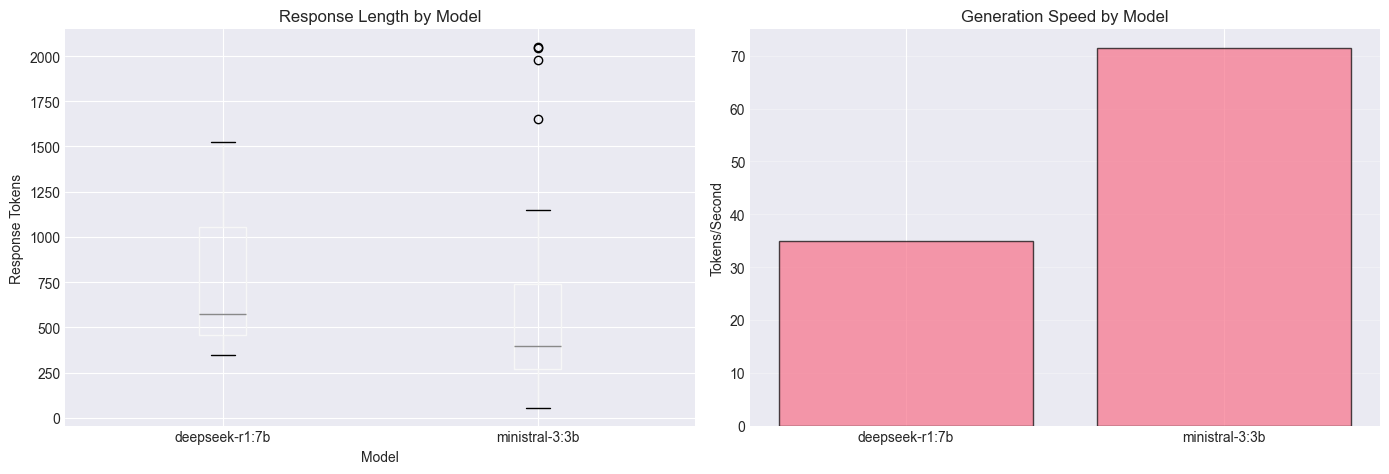

✓ Saved: results/figures/efficiency_analysis.png


In [21]:
# Visualize efficiency
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Response length by model
df.boxplot(column='response_tokens', by='model', ax=axes[0])
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Response Tokens')
axes[0].set_title('Response Length by Model')
axes[0].get_figure().suptitle('')

# Generation speed
models = token_stats.index
speeds = token_stats['tokens_per_sec']
axes[1].bar(models, speeds, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Tokens/Second')
axes[1].set_title('Generation Speed by Model')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/figures/efficiency_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: results/figures/efficiency_analysis.png")

## 13. Summary Findings

In [22]:
print("\n" + "=" * 80)
print("KEY FINDINGS SUMMARY")
print("=" * 80)

# 1. Model size effect
print("\n1. MODEL SIZE EFFECT:")
for model in df['model'].unique():
    mean = df[df['model'] == model]['mean_score'].mean()
    print(f"   {model}: {mean:.2f}/5")

# 2. Best strategy
print("\n2. PROMPTING STRATEGY EFFECTIVENESS:")
for strategy in df['strategy'].unique():
    mean = df[df['strategy'] == strategy]['mean_score'].mean()
    count = len(df[df['strategy'] == strategy])
    print(f"   {strategy}: {mean:.2f}/5 (n={count})")

# 3. Task difficulty
print("\n3. TASK DIFFICULTY:")
task_means = df.groupby('task_id')['mean_score'].mean().sort_values()
print(f"   Easiest: {task_means.index[-1]} ({task_means.iloc[-1]:.2f})")
print(f"   Hardest: {task_means.index[0]} ({task_means.iloc[0]:.2f})")
print(f"   Range: {task_means.max() - task_means.min():.2f}")

# 4. Variance
print("\n4. SCORE CONSISTENCY:")
print(f"   Overall std: {df['mean_score'].std():.2f}")
for model in df['model'].unique():
    std = df[df['model'] == model]['mean_score'].std()
    print(f"   {model} std: {std:.2f}")

# 5. Efficiency
print("\n5. EFFICIENCY:")
for model in token_stats.index:
    speed = token_stats.loc[model, 'tokens_per_sec']
    avg_time = token_stats.loc[model, 'duration']
    print(f"   {model}: {speed:.1f} tokens/sec, {avg_time:.1f}s avg")

print("\n" + "=" * 80)
print(f"\nAnalysis complete. Results saved to: results/figures/")
print("=" * 80)


KEY FINDINGS SUMMARY

1. MODEL SIZE EFFECT:
   ministral-3:3b: 4.64/5
   deepseek-r1:7b: 4.50/5

2. PROMPTING STRATEGY EFFECTIVENESS:
   cot: 4.47/5 (n=10)
   zero_shot: 4.37/5 (n=20)
   few_shot: 4.86/5 (n=20)

3. TASK DIFFICULTY:
   Easiest: task_05_comprehension (5.00)
   Hardest: task_06_commonsense (3.53)
   Range: 1.47

4. SCORE CONSISTENCY:
   Overall std: 0.79
   ministral-3:3b std: 0.74
   deepseek-r1:7b std: 0.88

5. EFFICIENCY:
   deepseek-r1:7b: 35.0 tokens/sec, 20.9s avg
   ministral-3:3b: 71.4 tokens/sec, 8.7s avg


Analysis complete. Results saved to: results/figures/


## 14. Export Summary Report

In [23]:
# Create summary report
report_path = Path("results/analysis_summary.txt")

with open(report_path, 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("LLM EVALUATION ANALYSIS SUMMARY\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("=" * 80 + "\n\n")
    
    f.write(f"Total Experiments: {len(df)}\n")
    f.write(f"Models: {df['model'].unique().tolist()}\n")
    f.write(f"Strategies: {df['strategy'].unique().tolist()}\n")
    f.write(f"Tasks: {df['task_id'].nunique()}\n\n")
    
    f.write("OVERALL STATISTICS\n")
    f.write("-" * 80 + "\n")
    f.write(f"Mean Score: {df['mean_score'].mean():.2f} (±{df['mean_score'].std():.2f})\n")
    f.write(f"Median Score: {df['mean_score'].median():.2f}\n")
    f.write(f"Range: {df['mean_score'].min():.2f} - {df['mean_score'].max():.2f}\n\n")
    
    f.write("MODEL COMPARISON\n")
    f.write("-" * 80 + "\n")
    f.write(model_stats.to_string())
    f.write("\n\n")
    
    f.write("STRATEGY COMPARISON\n")
    f.write("-" * 80 + "\n")
    f.write(strategy_stats.to_string())
    f.write("\n\n")
    
    f.write("TASK DIFFICULTY\n")
    f.write("-" * 80 + "\n")
    f.write(task_stats.to_string())
    f.write("\n\n")
    
    f.write("=" * 80 + "\n")
    f.write("Figures saved to: results/figures/\n")
    f.write("Detailed data in: results/scores.csv\n")
    f.write("=" * 80 + "\n")

print(f"✓ Summary report saved: {report_path}")

✓ Summary report saved: results/analysis_summary.txt
